# Named Entity Recognition

Named Entity Recognition (NER) is a component of the information extraction process aimed at identifying and categorizing named entities within a text. These named entities can include organizations, individuals, locations, times, and more. Through NER, we can recognize and classify portions of text containing named entities, thereby providing a better understanding of the information contained within the text.

### Business Problem:
A large technology-based company faces a challenge in efficiently extracting important information from large volumes of text data, including documents, news articles, and social media posts. The company needs to identify entities such as person names, company names, geographic locations, and dates from the text accurately and quickly to gain insights and make informed decisions.

### Business Metrics:
To evaluate the success of the NER solution, the company can track the following business metrics:
1. **Accuracy**: The ability of the NER model to correctly identify entities in the text.
2. **Efficiency**: The time taken by the NER system to process a given amount of text and produce entity recognition results.
3. **Scalability**: The NER solution's ability to handle increasing amounts of text data without compromising performance.
4. **Precision and Recall**: Measures of the NER model's ability to accurately identify relevant entities (precision) and retrieve all relevant entities (recall) from the text.

### Solution:
To address the business problem, the company decides to develop an NER system using a combination of pretrained GloVe word embeddings and an LSTM-based neural network architecture. Here's how the solution will be implemented:
1. **Data Preparation**: The company collects and preprocesses text data for training and testing the NER model. The text data is cleaned, tokenized, and annotated with entity labels.
2. **Model Development**: The NER model is built using a pretrained GloVe embedding layer to represent words in a continuous vector space. An LSTM layer is then used to learn the sequential patterns and context of the text data. The model is trained on annotated data to recognize entities in the text.
3. **Evaluation**: The performance of the NER model is evaluated using metrics such as accuracy, precision, recall, and F1-score on a separate test dataset.
4. **Deployment**: Once trained and evaluated, the NER model is deployed into the company's production environment. It is integrated into existing text processing pipelines to automatically extract entities from incoming text data.
5. **Monitoring and Iteration**: The deployed NER system is monitored for performance and fine-tuned as needed to improve accuracy and efficiency. This includes retraining the model with additional annotated data and updating the model architecture based on advancements in NER techniques.

In [1]:
import numpy as np 
import pandas as pd 
import random 
from sklearn.metrics import classification_report
import os
from sklearn.model_selection import train_test_split

In [2]:
# read data
df = pd.read_csv("ner_dataset.csv", encoding="latin1")
# sanity check
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
# null value check
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [4]:
# Fill missing values in 'Sentence #' column using forward fill method
df['Sentence #'] = df['Sentence #'].ffill(axis=0)
# Display the DataFrame after filling missing values
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


## Data Definition

Based on the provided DataFrame information:

    - `Sentence #`: Represents the identifier for each sentence in the dataset. Each sentence is assigned a unique sentence number. This column contains non-null values of type object (string).
    
    - `Word`: Contains the individual words or tokens present in the sentences. This column consists of non-null values of type object (string).
    
    - `POS`: Stands for Part-of-Speech, indicating the grammatical category of each word or token. This column contains non-null values of type object (string).
    
    - `Tag`: Represents the named entity tag associated with each word or token. This column contains non-null values of type object (string).
    
    The dataset contains a total of 1048575 entries and 4 columns. All columns are of type object (string). The memory usage for the DataFrame is approximately 32.0+ MB.

  - **Tag Definition**:
  - `geo`: Represents a geographical entity.
  - `org`: Represents an organization entity.
  - `per`: Represents a person entity.
  - `gpe`: Represents a geopolitical entity.
  - `tim`: Represents a time indicator entity.
  - `art`: Represents an artifact entity.
  - `eve`: Represents an event entity.
  - `nat`: Represents a natural phenomenon entity.
  - `O`: Assigned if a word doesn't belong to any entity.

## Data Preparation

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils
import numpy as np
import gensim

The `NERDataset` class loads NER data from a CSV file, organizes it into sentences, and converts words and tags into numerical indices for model training. It's a vital part of the NER pipeline, simplifying data handling for model training.

In [9]:
# Define a custom dataset class for the NER data
class NERDataset(Dataset):
    def __init__(self, filepath, word_embeddings):
        self.data = pd.read_csv(filepath, encoding='latin1').fillna(method='ffill')
        
        # Create a list of unique words and tags
        self.words = list(set(self.data["Word"].values))
        self.tags = list(set(self.data["Tag"].values))
        
        # Create dictionaries for mapping words and tags to integers
        self.word2idx = {w: i+1 for i, w in enumerate(self.words)}
        self.tag2idx = {t: i for i, t in enumerate(self.tags)}
        
        self.sentences = self._get_sentences()
        self.word_embeddings = word_embeddings
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence = self.sentences[index]
        words = [word[0] for word in sentence]
        tags = [word[1] for word in sentence]
        
        # Convert words and tags to numerical values using the dictionaries
        x = [self.word2idx.get(w, 0) for w in words]  # Use 0 for unknown words
        y = [self.tag2idx[t] for t in tags]
        
        return torch.tensor(x), torch.tensor(y)
    
    def _get_sentences(self):
        # Group the data by sentence number
        grouped = self.data.groupby("Sentence #")
        sentences = []
        for _, group in grouped:
            words = group["Word"].values.tolist()
            tags = group["Tag"].values.tolist()
            sentence = list(zip(words, tags))
            sentences.append(sentence)
        return sentences

The `load_glove_embeddings` function reads pretrained GloVe word embeddings from a file and stores them in a dictionary, mapping each word to its corresponding embedding vector.

In [11]:
# Load pretrained GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [20]:
# Define hyperparameters and train the model
BATCH_SIZE = 32
HIDDEN_DIM = 128  # Hidden dimension
OUTPUT_DIM = len(dataset.tags)  # Output dimension
LEARNING_RATE = 0.01
EPOCHS = 100

In [12]:
from gensim.scripts.glove2word2vec import glove2word2vec

# Convert GloVe model to Word2Vec format
glove_input_file = 'glove.6B.100d.txt' 
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted GloVe model in Word2Vec format
word_embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_7072\3023295864.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [13]:
# Load the dataset
dataset = NERDataset("ner_dataset.csv", word_embeddings)

In [16]:
def collate_fn(batch):
    # Sort the batch by length for efficient padding
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    # Unpack the batch
    inputs, targets = zip(*batch)
    # Pad sequences to have equal length
    inputs = rnn_utils.pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = rnn_utils.pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

In [17]:
# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Simple BiLSTM-based NER model with pretrained word embeddings

In [14]:
# Define a simple BiLSTM-based NER model with pretrained word embeddings
class NERModel(nn.Module):
    def __init__(self, word_embeddings, hidden_dim, output_dim, bidirectional=True):
        super().__init__()
        
        self.embedding_dim = word_embeddings.vector_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings.vectors))
        self.embedding.weight.requires_grad = False  # Freeze embedding layer
        
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output)
        return output

### MCO - Model Criterion Optimizer

In [21]:
# Define the model
model = NERModel(word_embeddings, HIDDEN_DIM, OUTPUT_DIM)
# Define optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
# Define Criterion
criterion = nn.CrossEntropyLoss()

## Training Loop

In [22]:
# Training loop
train_losses = []
val_losses = []

best_val_loss = float('inf')  # Inisialisasi dengan nilai tak terhingga
best_model_state = None

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for inputs, targets in train_loader:  # Mengambil inputs dan targets langsung dari train_loader
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.view(-1, OUTPUT_DIM), targets.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        for inputs_val, targets_val in val_loader:  # Mengambil inputs dan targets langsung dari val_loader
            output_val = model(inputs_val)
            loss_val = criterion(output_val.view(-1, OUTPUT_DIM), targets_val.view(-1))
            val_loss += loss_val.item() * inputs_val.size(0)
        val_loss /= len(val_data)
        val_losses.append(val_loss)
        
        # Simpan model jika val_loss saat ini lebih baik daripada yang sebelumnya
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 0.1691, Val Loss: 0.1117
Epoch 2, Train Loss: 0.0974, Val Loss: 0.0975
Epoch 3, Train Loss: 0.0813, Val Loss: 0.0946
Epoch 4, Train Loss: 0.0723, Val Loss: 0.0952
Epoch 5, Train Loss: 0.0664, Val Loss: 0.0977
Epoch 6, Train Loss: 0.0620, Val Loss: 0.0937
Epoch 7, Train Loss: 0.0588, Val Loss: 0.0966
Epoch 8, Train Loss: 0.0562, Val Loss: 0.0958
Epoch 9, Train Loss: 0.0527, Val Loss: 0.0969
Epoch 10, Train Loss: 0.0516, Val Loss: 0.0974
Epoch 11, Train Loss: 0.0505, Val Loss: 0.1001
Epoch 12, Train Loss: 0.0486, Val Loss: 0.0975
Epoch 13, Train Loss: 0.0472, Val Loss: 0.1017
Epoch 14, Train Loss: 0.0461, Val Loss: 0.1017
Epoch 15, Train Loss: 0.0453, Val Loss: 0.1012
Epoch 16, Train Loss: 0.0447, Val Loss: 0.0998
Epoch 17, Train Loss: 0.0438, Val Loss: 0.1019
Epoch 18, Train Loss: 0.0429, Val Loss: 0.1008
Epoch 19, Train Loss: 0.0416, Val Loss: 0.1027
Epoch 20, Train Loss: 0.0425, Val Loss: 0.1017
Epoch 21, Train Loss: 0.0412, Val Loss: 0.1071
Epoch 22, Train Loss: 

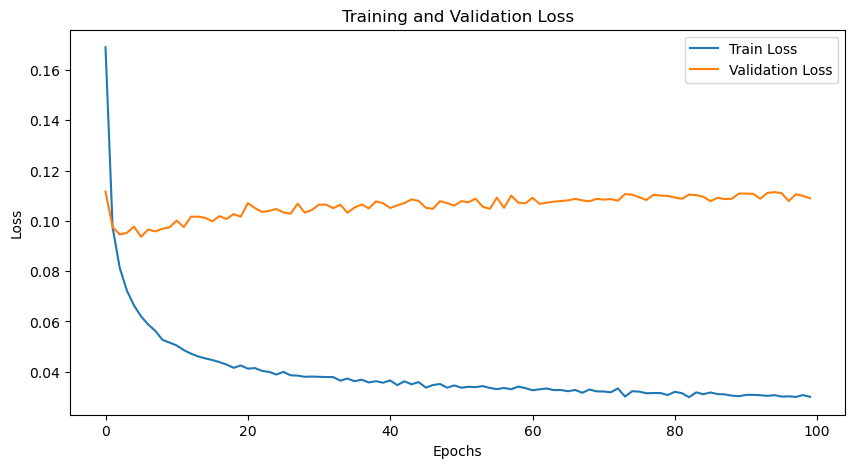

In [23]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the best model
torch.save(best_model_state, 'best_ner_model_glove.pth')

In [25]:
# Load the best model
best_model = NERModel(word_embeddings, HIDDEN_DIM, OUTPUT_DIM)
best_model.load_state_dict(torch.load('best_ner_model_glove.pth'))

# Function to predict tags for a given sentence
def predict_tags(sentence, model):
    words = sentence.split()
    x = [dataset.word2idx.get(word, 0) for word in words]
    x = torch.tensor(x).unsqueeze(0)
    with torch.no_grad():
        output = model(x)
        _, predicted_tags = torch.max(output, dim=2)
    predicted_tags = predicted_tags.squeeze().tolist()
    predicted_labels = [dataset.tags[idx] for idx in predicted_tags]
    return predicted_labels

# Test prediction on a sample sentence
sample_sentence = "Jeff Bezos is the founder of Amazon"
predicted_tags = predict_tags(sample_sentence, best_model)
print(sample_sentence)
print(predicted_tags)

Jeff Bezos is the founder of Amazon
['B-per', 'B-geo', 'O', 'O', 'O', 'O', 'B-geo']
